## HOW VOLATILITY DYNAMICS CHANGE PATH-DEPENDENT PRICES
### GBM vs GARCH(1,1) FOR ASIAN CALL OPTIONS

This notebook uses historical SPY data from $\texttt{yfinance}$ to investigate how volatility dynamic affect the pricing of arithmetic Asian call options.

Why arithmetic Asian call options? Arithmetic Asian options are derivative-based financial instrument whose payoff is determined by the average price ($\bar{S}$) of the underlying asset over a period of time. The payoff is given by 
$$\textrm{Payoff} = \textrm{max}(\bar{S}-K,0),\ \ \bar{S} = \frac{1}{N} \sum^N_{i=0} S_{t_i}$$
where $K$ is the strike price at expiration time $T$. Unlike European options where only the price at expiration matters, the effects of considering the average price is that the path volatility matters.

Volatility dynamics change the simulated path of stocks. Geometric Brownian Motion (GBM) is an industry standard used to simulate stock paths, where GBM assumes a constant volatility over a given period of time. However, in reality, volatility is not constant. A varying volatility will produce different stock path dynamics, which will affect the overall price of a path-dependent option. In this notebook, GBM and GARCH(1,1) models are explored to compare the difference between constant volatility and volatility clustering models. 

### General configuration: imports and controlling variables

In [1]:
# General imports
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.optimize import minimize
from statsmodels.stats.diagnostic import acorr_ljungbox
import yfinance as yf

In [2]:
# Configuration variables
ticker = 'SPY'
start, end = '2015-01-01', None # about 10.5 years of data
tradingDays = 252
r = 0.04 # annual risk-free
T = 0.5  # time to expiration 6 months
K = None # strike price. Assume at the moment strike price when None
nSims = 100000 
nSteps = int(tradingDays * T)  # Assume 1 step a day

### Data and autocorrelation check
Historical data is going to be used to get more realistic parameters for the modelling of stock paths.
Also, an autocorrelation test can be used to check if there is volatility dependency which would justify a model like GARCH(1,1)

In [3]:
# Download data
data = yf.download(ticker, start=start, end=end, auto_adjust=True)['Close'].dropna()

[*********************100%***********************]  1 of 1 completed


In [4]:
dataLogReturns = np.log(data.pct_change()+1).dropna()
print(acorr_ljungbox(dataLogReturns, lags=20))

       lb_stat     lb_pvalue
1    39.838298  2.758821e-10
2    54.052624  1.830720e-12
3    56.224711  3.761757e-12
4    66.724765  1.114255e-13
5    71.274595  5.562725e-14
6    92.716806  8.255799e-18
7   132.687444  1.724386e-25
8   160.631137  1.180213e-30
9   195.285235  3.222026e-37
10  200.347370  1.365961e-37
11  200.617940  5.536882e-37
12  201.170202  1.870009e-36
13  209.925683  1.244032e-37
14  213.918134  7.781485e-38
15  231.273979  8.757538e-41
16  237.705276  1.704946e-41
17  238.940958  3.756582e-41
18  242.916527  2.241653e-41
19  243.508883  6.366094e-41
20  243.626176  2.196664e-40


Very small p-values (<0.05) means the null hypothesis that the data is not autocorrelated is likely rejected.
Thus, data of the ticker is likely autocorrelated. Therefore, the ticker likely contains clusters of volatilities which means GARCH(1,1) should perform well.

### More Realistic Conditions
Historical data is used to get a reasonable estimate of the mean return and mean volatility of the underlying asset

In [5]:
# Data dependent configuration variables
S0 = (data.iloc[-1]).iloc[0] # Latest stock price
K = S0 if K is None else K # Use the latest stock price as the strike price if no strike price defined

In [6]:
# Compute daily returns
dailyLogReturns = np.log(data).diff().dropna().values                 # daily log returns
annualMeanHist = float(np.mean(dailyLogReturns)) * tradingDays        # historical annual mean return
annualVolHist = float(np.std(dailyLogReturns)) * np.sqrt(tradingDays) # historical annual volatility
print(f"S0={S0:.4f}, K={K:.4f}, T={T:.2f} yrs, r={r:.4f}, annual mean return={annualMeanHist:.4f}, annual volatility={annualVolHist:.4f}")

S0=670.9700, K=670.9700, T=0.50 yrs, r=0.0400, annual mean return=0.1262, annual volatility=0.1789


### GARCH(1,1) Model

The GARCH(1,1) model assumes the daily log returns of the underlying stock are driven by the function
$$ r_t = \mu_{\Delta t} + \epsilon_t,\ \ \epsilon_t \sim \mathcal{N}(0,h_t) $$
$$ h_t=\omega+\alpha\epsilon^2_{t-1}+\beta h_{t-1} $$
where $\mu_{\Delta t}$ is the daily drift of the stock, and $\epsilon_t$ is the shock factor that affects the future volatility. The shock factor is a function standard normal distribution with volatility $h_t$. The current volatility is related to the previous volatilities ($h_{t-1}$) through a parameter $\beta$, and the previous shock factor $\epsilon_{t-1}$ through a parameter $\alpha$. Also, the baseline volatility of the day is given by $\omega$.

To get the daily log returns, it is necessary to find proper values for the volatility parameters $\omega$, $\alpha$, $\beta$. The parameters can be estimated using historical data by fitting the GARCH model to the daily log returns using a maximum-likelihood estimation. 

The log-likelihood of the GARCH(1,1) model is given by
$$ \ell = \sum^T_{t=1}\log\left(f(r_t)\right) = \sum^T_{t=1} \log\left(\mathcal{N}(0,h_t)\right) = -\frac{1}{2}\sum^{T}_{t=1}\left[\log(2\pi)+\log(h_t)+\frac{(r_t-\mu)^2}{h_t}\right] $$
where $h_t$ is built recursively. The recursive GARCH rule defines
$$ \epsilon_{t-1}=r_{t-1}-\mu,\ \ h_t=\omega+\alpha\epsilon^2_{t-1}+\beta h_{t-1}$$.
The best fit is achieved when the GARCH(1,1) log-likelihood is maximixed. The function below calculates the log-likelihood for a given set of parameters.

In [7]:
# Assume the daily log-returns follow a GARCH(1,1) model. 
# Find the GARCH(1,1) free-parameter values that best describe the daily log-returns
def garch_nll(params, dailyLogReturns):
    # Unpack parameters
    omega, alpha, beta, mu = params
    # Generic constraints to ensure GARCH(1,1) behaves as expected
    # Variance cant be negative, so omega, alpha and beta must be greater than 0
    # If alpha or beta are greater than 1, they will quickly blow up the variance through the recursive steps. Constraint their value.
    # If the constraints are not satisfied, return a large value which will penalize the optimizer.
    if omega <= 0 or alpha < 0 or beta < 0 or (alpha+beta) >= 1: return 1e10
    # Number of steps 
    n = len(dailyLogReturns)
    # Create GARCH variance
    h = np.empty(n)
    h0 = omega / (1 - alpha - beta) # Assume the starting variance is the unconditional GARCH variance
    # Ensure the starting variance is not tooooo small
    h[0] = max(h0, 1e-12)
    residual = dailyLogReturns - mu # How far returns are from their mean
    # Recursively compute the GARCH variances
    for t in range(1, n):
        h[t] = omega + alpha * residual[t-1]**2 + beta * h[t-1]
        if h[t] <= 0: return 1e10
    # Negative gaussian log-likelihood
    return 0.5*np.sum(np.log(2*np.pi) + np.log(h) + (residual**2)/h)

### Finding the GARCH(1,1) parameters using historical data

To obtain the parameters the log-likelihood function is maximixed. This can be achieved with the help of an optimizer that takes the log-likelihood function for the GARCH(1,1) model and finds the most suitable parameters.

However, there are constraints on the parameter values to ensure proper behavior of the function. First of all, the parameters need to be positive. Additionally, for proper behavior, $\alpha+\beta<1$. This is because otherwise the volatility will quickly blow up. To include this inequality constraint, the optimizer is runned with the usual ```SLSQP``` algorithm, which can handle bounds and inequality constraints.




In [8]:
# Starting guesses for the optimizer
var = np.var(dailyLogReturns)                                            # Gives scale of volatility
x0 = np.array([var*0.01, 0.05, 0.90-0.05, np.mean(dailyLogReturns)])     # Small omega, alpha+beta < 1, mu is just the mean of log returns
bounds = [(1e-12, None), (1e-6, 1-1e-6), (1e-6, 1-1e-6), (None, None)]   # Beta can be small but not negative, alpha and beta in (0,1) range, mu has no bounds
cons = ({"type": "ineq", "fun": lambda p: 1.0 - (p[1]+p[2]) + 1e-8},)    # Constraint (alpha+beta < 1), the 1e-8 is just for padding.
# Run the optimizer using the standard SLSQP algorithm to handle bounds and constraints.
optimizerResult = minimize(garch_nll, x0, args=(dailyLogReturns,), method='SLSQP', bounds=bounds, constraints=cons, options={'maxiter': 2000})
omega, alpha, beta, mu = optimizerResult.x
print(f"GARCH params: omega={omega:.3e}, alpha={alpha:.3f}, beta={beta:.3f}, mu={mu:.3e} (alpha+beta={alpha+beta:.3f})")

/var/folders/yx/cnrtsbmj7kj0jxp8thlf877w0000gn/T/ipykernel_77643/2086702211.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  h[t] = omega + alpha * residual[t-1]**2 + beta * h[t-1]


GARCH params: omega=1.270e-06, alpha=0.050, beta=0.850, mu=5.007e-04 (alpha+beta=0.900)


### Simulating paths

As demonstrated in class, GBM paths prices evolve as follow
$$ S_t = S_{t-1}e^{\left(r-\frac{1}{2}\sigma^2\right)dt+\sigma\sqrt{dt}\mathcal{N}(0,1)}$$

The GARCH(1,1) model paths can be defined as
$$ S_t = S_{t-1}e^{r_t}=S_{t-1}e^{\mu_{\Delta t}+\sqrt{h_t}\mathcal{N}(0,1)} $$

In [9]:
# Risk neutral daily drift assumption
driftDaily = r / tradingDays

In [10]:
# Path simulators
def gbmSimPaths(S0, r, sigmaAnnual, t, nSims, nSteps):
    rng   = np.random.default_rng() # Start random generator
    dt    = t / nSteps
    drift = (r - 0.5*sigmaAnnual**2)*dt
    vol   = sigmaAnnual*np.sqrt(dt)
    S     = np.empty((nSims, nSteps+1)); S[:,0] = S0
    for t in range(1, nSteps+1):
        noise = rng.standard_normal(nSims)
        S[:,t] = S[:,t-1]*np.exp(drift + vol*noise)
    return S

def garchSimPaths(S0, driftDaily, omega, alpha, beta, t, nSims, nSteps):
    rng = np.random.default_rng()
    S   = np.empty((nSims, nSteps+1))
    S[:,0] = S0
    h0  = omega / max(1e-8, (1 - alpha - beta))
    h   = np.full(nSims, max(h0, 1e-12))
    for t in range(1, nSteps+1):
        noise = rng.standard_normal(nSims)
        dailyLogReturns = driftDaily + np.sqrt(h)*noise
        S[:,t] = S[:,t-1]*np.exp(dailyLogReturns)
        residual = dailyLogReturns - driftDaily
        h = omega + alpha*(residual**2) + beta*h
        h = np.maximum(h, 1e-14)
    return S

### Arithmetic Asian call option price and error

Simulated paths can be used to price arithmetic Asian call options. Note that the paths project future expectations, so once the arithmetic Asian call option fair price is found at expiration, it needs to be discounted to the present.

Additionally, the payoff distribution has a standard deviation. The Monte Carlo standard error is the statistical error of the simulation given by
$$ \textrm{MC}_{\textrm{error, T}} = \frac{\sigma(\textrm{Payoff})}{\sqrt{N_{\textrm{sims}}}}$$
However, this error corresponds to the future payoff error, so it needs to be discounted.

The function below returns the discounted price using simulated paths and the discounted standard error.

In [11]:
# Asian call price
def asianCallArithmeticPrice(SPaths, r, t, K, include0=True):
    Sbar = SPaths.mean(axis=1) if include0 else SPaths[:,1:].mean(axis=1)
    payoff = np.maximum(Sbar - K, 0.0)
    discount = np.exp(-r*t)
    price = discount*payoff.mean()
    mcError = discount*payoff.std(ddof=1)/np.sqrt(len(payoff)) # Monte Carlo standard error (simulation noise)
    return price, mcError

### Pricing using GBM vs GARCH(1,1)

GBM and GARHC(1,1) stock paths are simulated. The price at 95\% CL for each group of stock paths is computed

In [12]:
# Run and compare
print(f"GBM parameters: sigma={annualVolHist:.4f}")
print(f"GARCH parameters: omega={omega:.4f}, alpha={alpha:.4f}, beta={beta:.4f}")
gbmPaths   = gbmSimPaths(S0, r, annualVolHist, T, nSims, nSteps)
garchPaths = garchSimPaths(S0, driftDaily, omega, alpha, beta, T, nSims, nSteps)

gbmAsianCallArithmeticPrice, gbmError       = asianCallArithmeticPrice(gbmPaths, r, T, K)
garchAsianCallArithmeticPrice, garchError   = asianCallArithmeticPrice(garchPaths, r, T, K)

print(f"Asian (GBM):   price={gbmAsianCallArithmeticPrice:,.4f}, error={1.96*gbmError:,.4f}")
print(f"Asian (GARCH): price={garchAsianCallArithmeticPrice:,.4f}, error={1.96*garchError:,.4f}")

GBM parameters: sigma=0.1789
GARCH parameters: omega=0.0000, alpha=0.0500, beta=0.8500
Asian (GBM):   price=22.7596, error=0.1987
Asian (GARCH): price=10.1269, error=0.0702


### Useful distributions

1. GBM stock paths
2. GARCH(1,1) stock paths
3. Compare the stock paths obtained with GBM and GARCH(1,1) models.
4. Check the distribution of the price at expiration.
5. Check the average price distributions.
6. Check the MC error as a function of simulations.

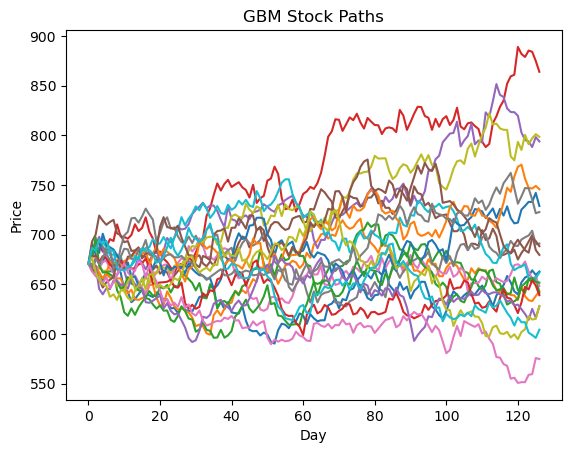

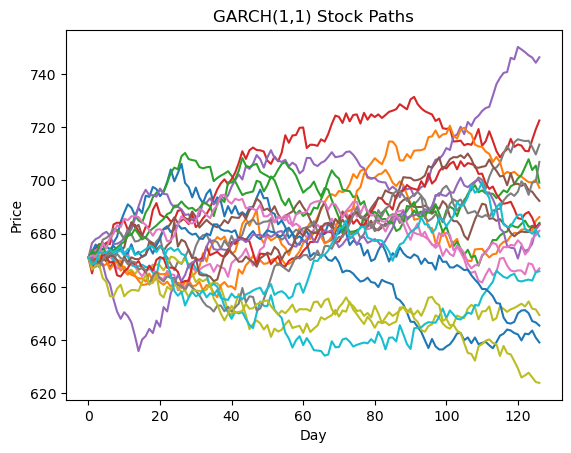

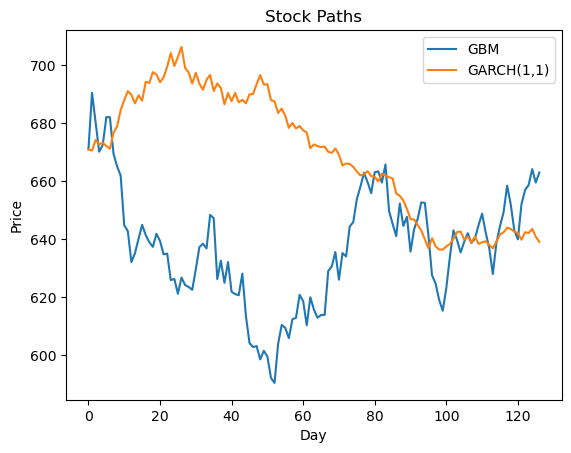

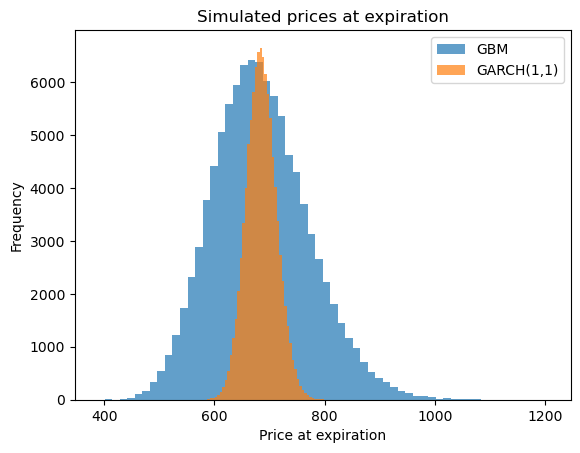

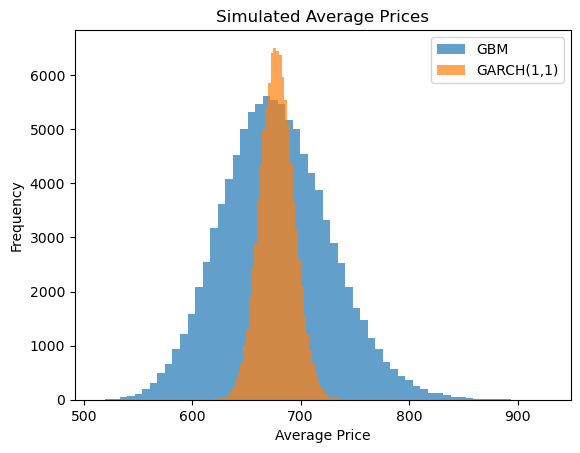

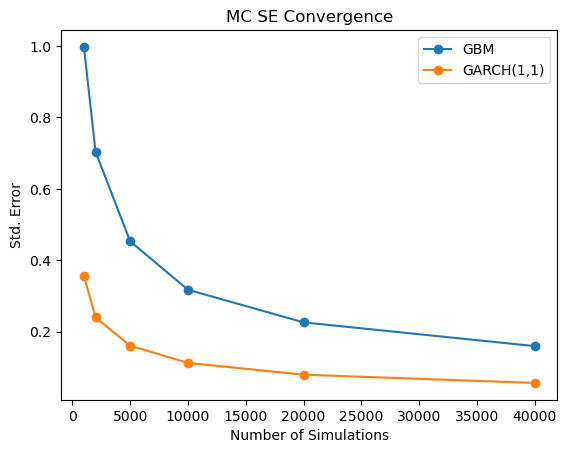

In [13]:
# ----- Figures -----

# 20 GBM stock paths
paths = 20
plt.figure()
for i in range(paths):
    plt.plot(gbmPaths[i])
plt.title('GBM Stock Paths')
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()
#plt.savefig("gbmStockPaths.png")

# 20 GBM stock paths
paths = 20
plt.figure()
for i in range(paths):
    plt.plot(garchPaths[i])
plt.title('GARCH(1,1) Stock Paths')
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()
#plt.savefig("garchStockPaths.png")

# 1v1 sample paths
plt.figure()
plt.plot(gbmPaths[0],label="GBM")
plt.plot(garchPaths[0], label="GARCH(1,1)")
plt.title('Stock Paths')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()
#plt.savefig("stockPaths.png")

# Price at expiration distributions
plt.figure()
plt.hist(gbmPaths[:,-1], bins=60, alpha=0.7, label='GBM')
plt.hist(garchPaths[:,-1], bins=60, alpha=0.7, label='GARCH(1,1)')
plt.title('Simulated prices at expiration')
plt.xlabel('Price at expiration')
plt.ylabel('Frequency')
plt.legend()
plt.show()
#plt.savefig("priceExpiration.png")

# Average price distributions
gbmSbar = gbmPaths.mean(axis=1)
garchSbar = garchPaths.mean(axis=1)
plt.figure()
plt.hist(gbmSbar, bins=60, alpha=0.7, label='GBM')
plt.hist(garchSbar, bins=60, alpha=0.7, label='GARCH(1,1)')
plt.title('Simulated Average Prices')
plt.xlabel('Average Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()
#plt.savefig("avgPrice.png")

# MC convergence (GBM example)
trials = np.array([1000, 2000, 5000, 10000, 20000, 40000])
gbmErrors, garchErrors = [], []
for m in trials:
    gbmPathsM = gbmSimPaths(S0, r, annualVolHist, T, m, nSteps)
    _, gbmErrorM = asianCallArithmeticPrice(gbmPathsM, r, T, K)
    gbmErrors.append(gbmErrorM)
    garchPathsM = garchSimPaths(S0, driftDaily, omega, alpha, beta, T, m, nSteps)
    _, garchErrorM = asianCallArithmeticPrice(garchPathsM, r, T, K)
    garchErrors.append(garchErrorM)
plt.figure()
plt.plot(trials, gbmErrors, marker='o', label="GBM")
plt.plot(trials, garchErrors, marker='o', label="GARCH(1,1)")
plt.title('MC SE Convergence')
plt.xlabel('Number of Simulations')
plt.ylabel('Std. Error')
plt.legend()
plt.show()
#plt.savefig("convergence.png")

### Evaluating the results

1. GBM produces higher Asian call option prices because the constant volatility amplifies the dispersion in the average price.
2. GARCH(1,1) generated smaller prices since volatility clustering and mean revision reduce the effective variance of the path average.
3. The 95% CL is smaller for the GARCH(1,1) model suggesting less statistical fluctuations in the dispersion of prices.
4. GBM is used for quoting and hedging, but GARCH(1,1) captures more realistic volatility clustering which is valuable for refining risk estimates and forecasting volatility trends.

